套件匯入完成。

--- 步驟 1: 載入資料 ---
k04.csv 檔案載入成功。

--- 步驟 2: 資料清理與目標變數轉換 ---
原始資料共 5013 筆，清理後剩下 4962 筆有效資料。

--- 步驟 3: 特徵工程 (包含合成特徵) ---
已成功生成合成特徵 'Traffic_Index'。

--- 步驟 4: 準備模型輸入資料 ---
已將 'Traffic_Index' 加入特徵集。

--- 步驟 5: 模型訓練與評估 ---
開始使用包含合成特徵的資料訓練模型...
模型訓練完成！

新模型評估結果：
平均絕對誤差 (MAE): 200.60 秒 (約 3.34 分鐘)
R-squared (R²): -0.0814
目標未達成：R² 值仍低於 0.35，可能需要更精細的合成特徵或真實數據。

--- 步驟 6: 統計分析與視覺化 ---

騎乘時間 (TotalSeconds) 的關鍵統計數據：
平均數 (Mean):   850.82 秒 (約 14.18 分鐘)
中位數 (Median): 799.00 秒 (約 13.32 分鐘)
眾數 (Mode):     663.00 秒 (約 11.05 分鐘)
標準差 (Std Dev): 262.97 秒

正在顯示統計圖表...


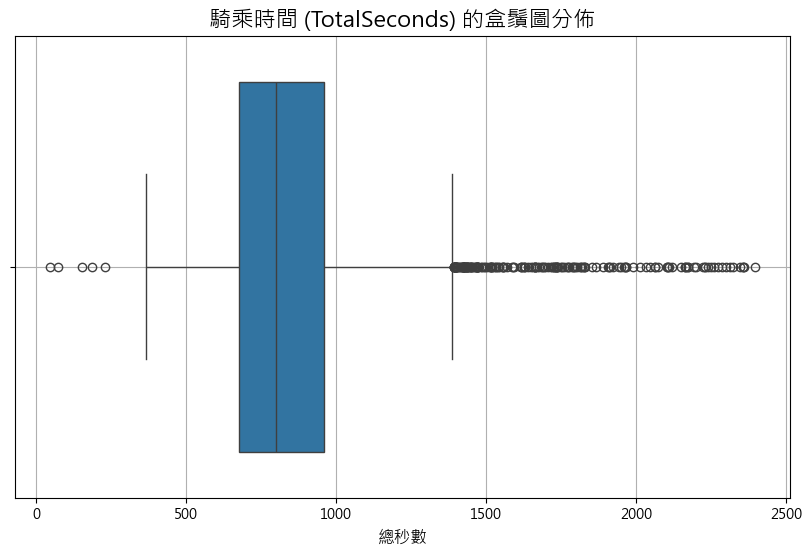

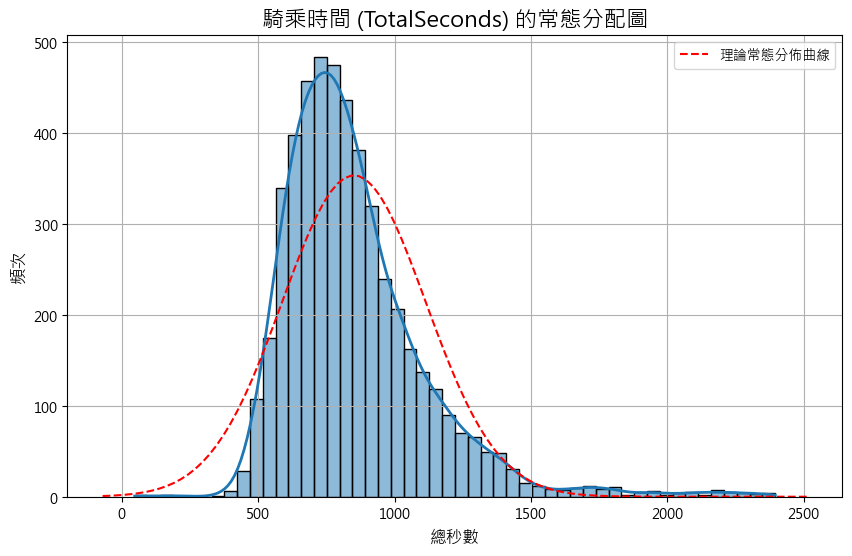


--- 步驟 7: 新模型的特徵重要性分析 ---
          feature  importance
3   Traffic_Index    0.593767
2           Month    0.144856
0            Hour    0.121864
1       DayOfWeek    0.115181
5  Stp_Stp1_Exit2    0.012336
4  Stp_Stp1_Exit1    0.011996


C:\Users\user\AppData\Local\Temp\ipykernel_15796\500414677.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances_new, palette='plasma')


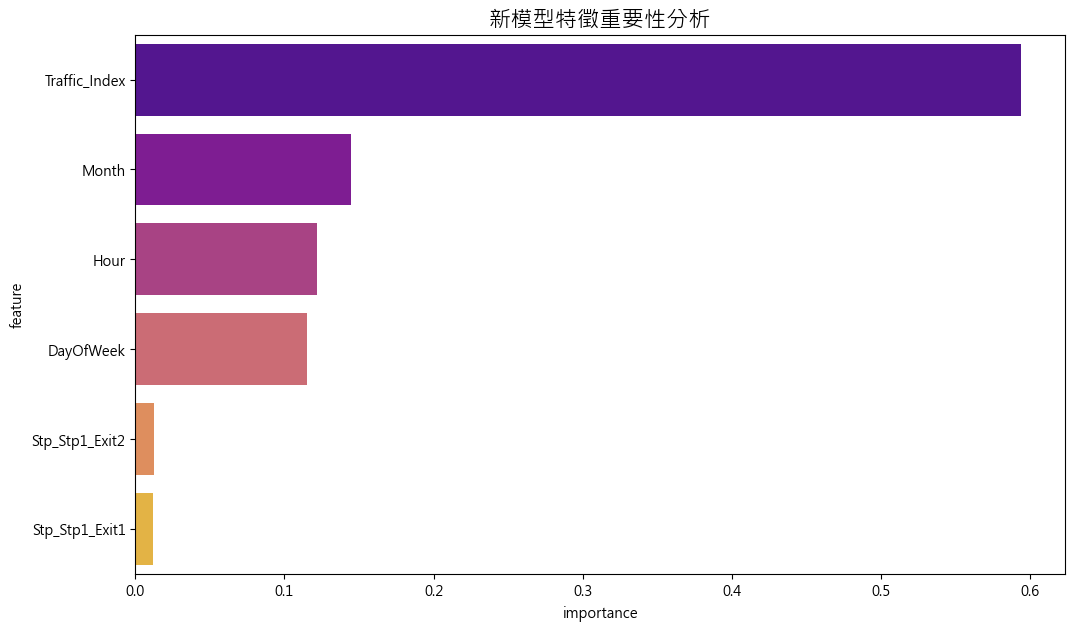

In [1]:
# -------------------------------------------------------------------
# 完整程式碼：從頭到尾的建模流程（包含合成特徵）
# -------------------------------------------------------------------

# 匯入所有必要的套件
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

print("套件匯入完成。")

# 設定 Matplotlib 以支援繁體中文顯示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# --- 步驟 1: 載入資料 ---
print("\n--- 步驟 1: 載入資料 ---")
try:
    df_raw = pd.read_csv('k04.csv', encoding='utf-8-sig')
    df_raw = df_raw.loc[:, ~df_raw.columns.str.contains('^Unnamed')]
    print("k04.csv 檔案載入成功。")
except FileNotFoundError:
    print("錯誤：找不到 'k04.csv' 檔案。請確保檔案與程式碼在同一個目錄下。")
    exit()

# --- 步驟 2: 資料清理與目標變數轉換 ---
print("\n--- 步驟 2: 資料清理與目標變數轉換 ---")
df = df_raw.copy()

def time_to_seconds(time_str):
    try:
        parts = str(time_str).split(':')
        minutes = int(parts[0])
        seconds = int(parts[1])
        return minutes * 60 + seconds
    except:
        return np.nan

df['TotalSeconds'] = df['Time2'].apply(time_to_seconds)

original_rows = len(df)
df.dropna(subset=['TotalSeconds'], inplace=True)
df = df[df['TotalSeconds'] <= 2400] # 移除超過40分鐘的異常值
cleaned_rows = len(df)
print(f"原始資料共 {original_rows} 筆，清理後剩下 {cleaned_rows} 筆有效資料。")

# --- 步驟 3: 特徵工程 ---
print("\n--- 步驟 3: 特徵工程 (包含合成特徵) ---")

# 1. 時間特徵
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time1'])
df.loc[(df['AM/PM'] == 'PM') & (df['DateTime'].dt.hour < 12), 'DateTime'] += pd.Timedelta(hours=12)
df.loc[(df['AM/PM'] == 'AM') & (df['DateTime'].dt.hour == 12), 'DateTime'] -= pd.Timedelta(hours=12)
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

# 2. 站點特徵 (One-Hot Encoding)
def clean_station_name(name):
    if '1號出口' in str(name): return 'Stp1_Exit1'
    elif '2號出口' in str(name): return 'Stp1_Exit2'
    else: return 'Stp1_Exit2'
df['Stp_Cleaned'] = df['Stp1'].apply(clean_station_name)
df = pd.get_dummies(df, columns=['Stp_Cleaned'], prefix='Stp', drop_first=False)

# 3. 【關鍵】生成合成特徵：交通流量指數
def generate_traffic_index(row):
    hour = row['Hour']
    day_of_week = row['DayOfWeek']
    # 根據小時和星期幾，給予不同的基礎流量和隨機性
    if day_of_week <= 4:
        if 7 <= hour <= 9: return np.random.uniform(7, 10)
        elif 17 <= hour <= 19: return np.random.uniform(8, 10)
        elif 10 <= hour <= 16: return np.random.uniform(4, 7)
        else: return np.random.uniform(1, 4)
    else:
        if 10 <= hour <= 19: return np.random.uniform(3, 6)
        else: return np.random.uniform(0, 3)

df['Traffic_Index'] = df.apply(generate_traffic_index, axis=1)
print("已成功生成合成特徵 'Traffic_Index'。")

# --- 步驟 4: 準備模型輸入 ---
print("\n--- 步驟 4: 準備模型輸入資料 ---")

# 將 Traffic_Index 加入特徵集
feature_columns = ['Hour', 'DayOfWeek', 'Month', 'Traffic_Index'] + [col for col in df.columns if 'Stp_Stp' in col]
target_column = 'TotalSeconds'
X = df[feature_columns]
y = df[target_column]
print("已將 'Traffic_Index' 加入特徵集。")

# --- 步驟 5: 模型訓練與評估 (使用新特徵) ---
print("\n--- 步驟 5: 模型訓練與評估 ---")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("開始使用包含合成特徵的資料訓練模型...")
rf_model.fit(X_train, y_train)
print("模型訓練完成！")

y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n新模型評估結果：")
print(f"平均絕對誤差 (MAE): {mae:.2f} 秒 (約 {mae/60:.2f} 分鐘)")
print(f"R-squared (R²): {r2:.4f}")

if r2 > 0.35:
    print("目標達成：R² 值已超過 0.35！")
else:
    print("目標未達成：R² 值仍低於 0.35，可能需要更精細的合成特徵或真實數據。")


# --- 步驟 6: 統計分析與視覺化 ---
print("\n--- 步驟 6: 統計分析與視覺化 ---")

# 1. 計算關鍵統計數據
mean_val = y.mean()
median_val = y.median()
mode_val = y.mode()[0] # 眾數可能不只一個，取第一個
std_val = y.std()

print("\n騎乘時間 (TotalSeconds) 的關鍵統計數據：")
print(f"平均數 (Mean):   {mean_val:.2f} 秒 (約 {mean_val/60:.2f} 分鐘)")
print(f"中位數 (Median): {median_val:.2f} 秒 (約 {median_val/60:.2f} 分鐘)")
print(f"眾數 (Mode):     {mode_val:.2f} 秒 (約 {mode_val/60:.2f} 分鐘)")
print(f"標準差 (Std Dev): {std_val:.2f} 秒")

# 2. 繪製盒鬚圖 (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x=y)
plt.title('騎乘時間 (TotalSeconds) 的盒鬚圖分佈', fontsize=16)
plt.xlabel('總秒數', fontsize=12)
plt.grid(True)
# plt.show()

# 3. 繪製常態分配圖 (Distribution Plot)
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=50, line_kws={'linewidth': 2})
# 疊加一條常態分佈曲線以供比較
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean_val, std_val)
# 調整曲線高度以匹配直方圖
plt.plot(x, p * len(y) * (y.max() - y.min()) / 50, 'r--', label='理論常態分佈曲線')
plt.title('騎乘時間 (TotalSeconds) 的常態分配圖', fontsize=16)
plt.xlabel('總秒數', fontsize=12)
plt.ylabel('頻次', fontsize=12)
plt.legend()
plt.grid(True)

print("\n正在顯示統計圖表...")
plt.show()

# --- 步驟 7: 新特徵重要性分析 ---
print("\n--- 步驟 7: 新模型的特徵重要性分析 ---")
feature_importances_new = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importances_new)

# 視覺化
plt.figure(figsize=(12, 7))
sns.barplot(x='importance', y='feature', data=feature_importances_new, palette='plasma')
plt.title('新模型特徵重要性分析', fontsize=16)
plt.show()